This notebook estimates parameters of a drift function by solving a linear least-squares problem.

Parameters are estimated using global satellite data and drifters velocities for the period 2010–2020:

- Geostrophic currents from DUACS (https://doi.org/10.48670/moi-00148),
- Stokes drift from WAVERYS/MFWAM (https://doi.org/10.48670/moi-00022),
- Wind stress and 10 m velocity from ERA5 (https://doi.org/10.48670/moi-00185),
- Drogued-SVP drifters from the GPD (https://doi.org/10.25921/x46c-3620).

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cartopy.crs as ccrs
import cmocean.cm as cmo
from IPython.display import display, Math
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrd
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


from src.spherical_harmonics import gen_associated_legendre, sph_harm_y

# Problem overview

## 1. Original formulation from Rio *et al.* (2014)

The drift is modeled as:
$$
\vec{v}_d(\lambda, \phi) = \vec{u}_g(\lambda, \phi) + \beta(\lambda, \phi) \vec{\tau}(\lambda, \phi) e^{i \theta(\lambda, \phi)}
$$
where:

- $\vec{v}_d$ is the drifter velocity at the lat-lon point $(\lambda, \phi)$,
- $\vec{u}_g$ is the geostrophic current velocity,
- $\vec{\tau}$ is the wind stress at the ocean surface,
- $\beta$ and $\theta$ are the parameters of the empirical Ekman model.

$\beta$ and $\theta$ are subject to the following physical constraints: 
$$
\beta(\lambda, \phi) > 0, \ \forall (\lambda, \phi) \\
\theta(\lambda, \phi) \in [0, 2\pi], \ \forall (\lambda, \phi)
$$

## 2. Spatial dependency using spherical harmonics decompositions

In Rio **et al.**, $\beta$ and $\theta$ are fitted per spatial bins of 4° $\times$ 4°.
We propose to rather model their spatial dependency using spherical harmonics decompositions:
$$
\beta(\lambda, \phi) = \sum_l \sum_m \beta_m^l Y_m^l(\lambda, \phi) \\
\theta(\lambda, \phi) = \sum_l \sum_m \theta_m^l Y_m^l(\lambda, \phi)
$$

The resulting optimization problem is:
$$
\underset{\beta_m^l, \theta_m^l}{\operatorname{argmin}} \left \| \vec{v}_d(\lambda, \phi) - \vec{u}_g(\lambda, \phi) - \beta(\lambda, \phi) \vec{\tau}(\lambda, \phi) e^{i \theta(\lambda, \phi)} \right \|_2^2
$$
which is nonlinear and nonconvex.

## 3. Convex reformulation

Introducing the complex field:
$$
\alpha(\lambda, \phi) = \beta(\lambda, \phi) e^{i \theta(\lambda, \phi)}
$$
the problem becomes:
$$
\underset{\alpha_m^l}{\operatorname{argmin}} \left \| \vec{v}_d(\lambda, \phi) - \vec{u}_g(\lambda, \phi) - \alpha(\lambda, \phi) \vec{\tau}(\lambda, \phi) \right \|_2^2
$$,
where $\alpha(\lambda, \phi)$ is represented by a complex spherical harmonic decomposition:
$$
\alpha(\lambda, \phi) = \sum_l \sum_m \alpha_m^l Y_m^l(\lambda, \phi)
$$

This is a complex-valued least-squares problem, linear in the complex parameters $\alpha_m^l$.

The original $\beta$ and $\theta$ parameters of the empirical model of Rio *et al.* are recovered as:
$$
\beta = |\alpha| \\
\theta = arg(\alpha)
$$
which automatically satisfy the original constraints.

## 4. Computational challenge and optimization strategy

At the global scale, 10 years of data correspond to approximately about 20 million observations.
A direct least-squares solution would require materializing a dense design matrix of size 20M $\times$ 1k, which is prohibitive in memory ($\approx$ 500GB in complex128).

In anticipation of more physically and/or statistically elaborated (possibly nonlinear) models, we therefore recast the problem as a minibatch optimization problem, rather than relying on spatial binning.

Defining:
$$
\vec{x_i} = (\lambda_i, \phi_i, \vec{\tau}(\lambda_i, \phi_i)) \\
\vec{y_i} = \vec{v}_d(\lambda_i, \phi_i) - \vec{u}_g(\lambda_i, \phi_i)
$$
and the forward model:
$$
f_\alpha(\vec{x}) = \vec{\tau}(\lambda_i, \phi_i) \sum_l \sum_m \alpha_m^l Y_m^l(\lambda_i, \phi_i)
$$
we minimize the empirical risk:
$$
\mathcal{L}(\alpha) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left \| \vec{y_i} - f_\alpha(\vec{x_i}) \right \|^2_2
$$
The minimization is performed using gradient-based optimizers.

# Implementation

In [2]:
alpha_rio2014_da = xr.open_zarr("data/rio_2014/alpha.zarr")["__xarray_dataarray_variable__"]  # "reference"

beta_rio2014_da = xr.DataArray(
    jnp.abs(alpha_rio2014_da.values),
    coords=alpha_rio2014_da.coords,
    dims=alpha_rio2014_da.dims,
)
theta_rio2014_da = xr.DataArray(
    jnp.angle(alpha_rio2014_da.values, deg=True),
    coords=alpha_rio2014_da.coords,
    dims=alpha_rio2014_da.dims,
)

In [3]:
global_lat = alpha_rio2014_da.lat.values
global_lon = alpha_rio2014_da.lon.values

global_lat2d, global_lon2d = jnp.meshgrid(global_lat, global_lon, indexing="ij")

In [4]:
gdp_ds = xr.open_zarr("data/gdp_interp_2010-01-01_2023-01-01.zarr")

total_points = gdp_ds.points.size

x_full = (
    jnp.asarray(gdp_ds.lat.values), 
    jnp.asarray(gdp_ds.lon.values),
    jnp.asarray((gdp_ds.eastward_stress + 1j * gdp_ds.northward_stress).values)
)

u_drifters = jnp.asarray(gdp_ds.ve + 1j * gdp_ds.vn, dtype=jnp.complex128)
u_geos = jnp.asarray(gdp_ds.ugos + 1j * gdp_ds.vgos, dtype=jnp.complex128)

y_full = u_drifters - u_geos

In [5]:
# split into training and validation sets

key = jrd.key(0)

perm = jrd.permutation(key, total_points)
n_train = int(0.8 * total_points)

train_idx = perm[:n_train]
val_idx = perm[n_train:]

x_train = tuple(arr[train_idx] for arr in x_full)
y_train = y_full[train_idx]

x_val = tuple(arr[val_idx] for arr in x_full)
y_val = y_full[val_idx]

print(f"Training points: {y_train.size}, Validation points: {y_val.size}")

Training points: 16974964, Validation points: 4243741


## 1. Observations density

In [6]:
lat_grid = alpha_rio2014_da.lat.values
lon_grid = alpha_rio2014_da.lon.values

lat_edges = np.concatenate([
    [lat_grid[0] - (lat_grid[1] - lat_grid[0]) / 2],
    0.5 * (lat_grid[1:] + lat_grid[:-1]),
    [lat_grid[-1] + (lat_grid[1] - lat_grid[0]) / 2],
])

lon_edges = np.concatenate([
    [lon_grid[0] - (lon_grid[1] - lon_grid[0]) / 2],
    0.5 * (lon_grid[1:] + lon_grid[:-1]),
    [lon_grid[-1] + (lon_grid[1] - lon_grid[0]) / 2],
])

lon_obs = np.asarray(x_train[1])

# wrap to [-180, 180)
lon_obs = ((lon_obs + 180) % 360) - 180
lat_obs = np.asarray(x_train[0])

counts, _, _ = np.histogram2d(lat_obs, lon_obs, bins=[lat_edges, lon_edges])

density = jnp.asarray(counts)

In [7]:
def smooth_density(d, n_iter):
    for _ in range(n_iter):
        d = (
            0.25 * (
                jnp.roll(d, 1, axis=1) +  # lon periodic
                jnp.roll(d, -1, axis=1) +
                jnp.pad(d[1:, :], ((0, 1), (0, 0)), mode="edge") +
                jnp.pad(d[:-1, :], ((1, 0), (0, 0)), mode="edge")
            )
        )
    return d

In [109]:
density_smooth = smooth_density(density, n_iter=3)
density_smooth /= density_smooth.max()

density /= density.max()

density_weight = 1.0 / (1e-3 + density_smooth)
density_weight /= jnp.max(density_weight)

In [110]:
density_smooth_da = xr.DataArray(density_smooth, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)
density_da = xr.DataArray(density, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)

density_weight_da = xr.DataArray(density_weight, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)
density_weight2_da = 1 - density_smooth_da

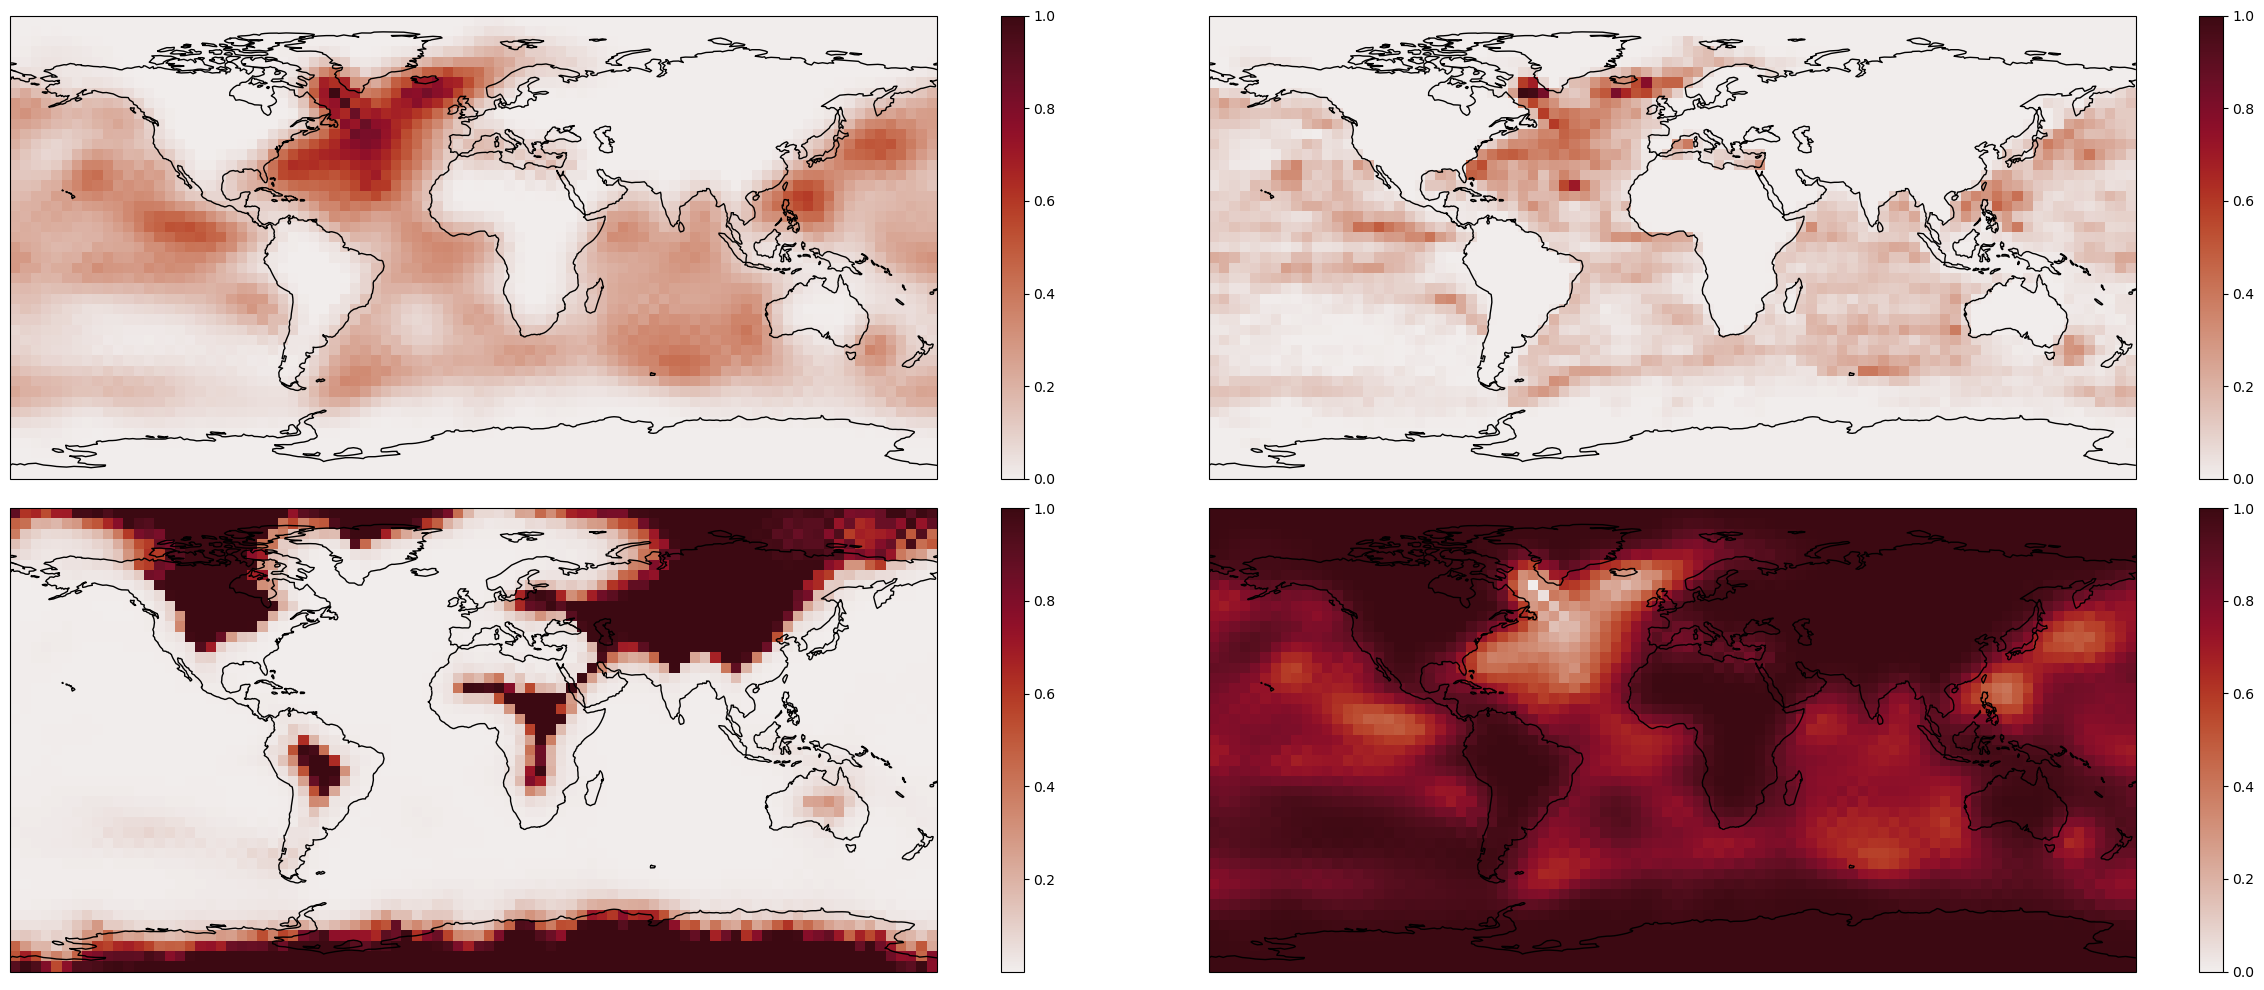

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10), subplot_kw={"projection": ccrs.PlateCarree()})

density_smooth_da.plot(ax=ax1, cmap=cmo.amp)
ax1.coastlines()

density_da.plot(ax=ax2, cmap=cmo.amp)
ax2.coastlines()

density_weight_da.plot(ax=ax3, cmap=cmo.amp)
ax3.coastlines()

density_weight2_da.plot(ax=ax4, cmap=cmo.amp)
ax4.coastlines()

fig.tight_layout()
plt.show()

## 2. Spherical harmonics decomposition

In [16]:
# Spherical harmonics setup

lmax = 12
n_coeffs = (lmax + 1) ** 2
idx = jnp.arange(n_coeffs)

L = jnp.repeat(jnp.arange(lmax + 1), 2 * jnp.arange(lmax + 1) + 1)
M = idx - L * (L + 1)

def get_sph_harm_bases(lat, lon):
    lat = jnp.deg2rad(lat)
    lon = jnp.deg2rad(lon)
    colat = jnp.pi / 2 - lat
    phi = lon % (2 * jnp.pi)

    legendre = gen_associated_legendre(lmax, colat, is_normalized=True)

    Y = jax.vmap(
        lambda l, m: sph_harm_y(l, m, colat, phi, n_max=lmax, legendre=legendre)
    )(L, M).T

    return Y

In [17]:
global_lat_flat = global_lat2d.ravel()
global_lon_flat = global_lon2d.ravel()

global_Y = get_sph_harm_bases(global_lat_flat, global_lon_flat)

In [112]:
# Loss function: mean squared error + regularization

# background values ("climatology" from Rio et al. 2014)
beta_bg = 0.25
theta_bg = jnp.deg2rad(48.0)
alpha_bg = beta_bg * jnp.exp(1j * theta_bg)

spectral_reg_weight = (L * (L + 1)) ** 2
spectral_reg_weight /= jnp.max(spectral_reg_weight)

density_weight_flat = density_weight.ravel()


def residual_fun(alpha_coeffs, alpha_bg, lat, lon, tau, y):
    Y = get_sph_harm_bases(lat, lon)

    alpha = Y @ alpha_coeffs
    alpha_bg = jnp.where(lat > 0, alpha_bg.conj(), alpha_bg)
    alpha += alpha_bg

    pred = alpha * tau

    residual = jnp.abs(y - pred) ** 2

    return residual


def loss_fun(alpha_coeffs, args):
    alpha_bg, (spectral_reg_lambda, density_reg_lambda), (lat, lon, tau), y = args

    residuals = residual_fun(alpha_coeffs, alpha_bg, lat, lon, tau, y)
    
    # latitude-weighted mean squared error
    weight = jnp.cos(jnp.deg2rad(lat))
    loss = jnp.sum(residuals * weight) / jnp.sum(weight)

    # spectral regularization
    spectral_reg = spectral_reg_lambda * jnp.sum(spectral_reg_weight * jnp.abs(alpha_coeffs) ** 2)

    # density regularization
    alpha_grid_flat = global_Y @ alpha_coeffs
    density_reg =  density_reg_lambda * jnp.sum(density_weight_flat * jnp.abs(alpha_grid_flat) ** 2)

    return loss + spectral_reg + density_reg


val_grad_loss_fun = jax.jit(jax.value_and_grad(loss_fun))

In [78]:
# Do optimization

alpha_init = jnp.full((n_coeffs,), 1 + 1j * 0)
maxiter = 5_000

val_losses = []

spectral_reg_lambdas = jnp.logspace(-6, -4, 3)
density_reg_lambdas = jnp.logspace(-8, -6, 3)

spectral_density_combinations = [
    (srl, drl) for srl in spectral_reg_lambdas for drl in density_reg_lambdas
]

for spectral_reg_lambda, density_reg_lambda in spectral_density_combinations:
    solver = jaxopt.LBFGS(fun=val_grad_loss_fun, value_and_grad=True, maxiter=maxiter)
    sol = solver.run(
        init_params=alpha_init, args=(alpha_bg, (spectral_reg_lambda, density_reg_lambda), x_train, y_train), 
        
    )

    alpha_init = sol.params  # warm start for next optimization

    val_loss = loss_fun(alpha_init, (alpha_bg, (0, 0), x_val, y_val))  # no regularization for validation
    val_losses.append(val_loss)

spectral_reg_lambda, density_reg_lambda = spectral_density_combinations[jnp.argmin(jnp.array(val_losses))]

print(
    f"Best regularization parameters: spectral_reg_lambda = {spectral_reg_lambda:.2e}, "
    f"density_reg_lambda = {density_reg_lambda:.2e} ; validation loss = {jnp.min(jnp.array(val_losses)):.4e}"
)

Best regularization parameters: spectral_reg_lambda = 1.00e-04, density_reg_lambda = 1.00e-06 ; validation loss = 6.0006e-02


In [120]:
solver = jaxopt.LBFGS(fun=val_grad_loss_fun, value_and_grad=True, maxiter=maxiter)
sol = solver.run(init_params=alpha_init, args=(alpha_bg, (1e-4, 1e-3), x_full, y_full))

print(f"Solve took {sol.state.iter_num} iterations, final loss = {sol.state.value:.4e}")

Solve took 66 iterations, final loss = 6.1576e-02


In [121]:
alphas_fit = sol.params
betas_fit = jnp.abs(alphas_fit)
thetas_fit = jnp.angle(alphas_fit, deg=True)

In [122]:
global_alpha = global_Y @ alphas_fit

global_alpha = global_alpha.reshape(alpha_rio2014_da.shape)

global_alpha += jnp.where(global_lat2d > 0, alpha_bg.conj(), alpha_bg)

global_beta = jnp.abs(global_alpha)
global_theta = jnp.angle(global_alpha, deg=True)

In [123]:
beta_fit_da = xr.DataArray(global_beta, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)
theta_fit_da = xr.DataArray(global_theta, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)

In [124]:
beta_fit_m_da = beta_fit_da * ~np.isnan(beta_rio2014_da)
theta_fit_m_da = theta_fit_da * ~np.isnan(theta_rio2014_da)

In [125]:
display(Math(
    r"\beta_e = {:.2f} \,\text{{m}}^2\text{{s}}/\text{{kg}}, \, \theta_e = {:.2f} \,\degree".format(
        beta_fit_m_da.mean().item(), np.abs(theta_fit_m_da).mean().item()
    )
))

<IPython.core.display.Math object>

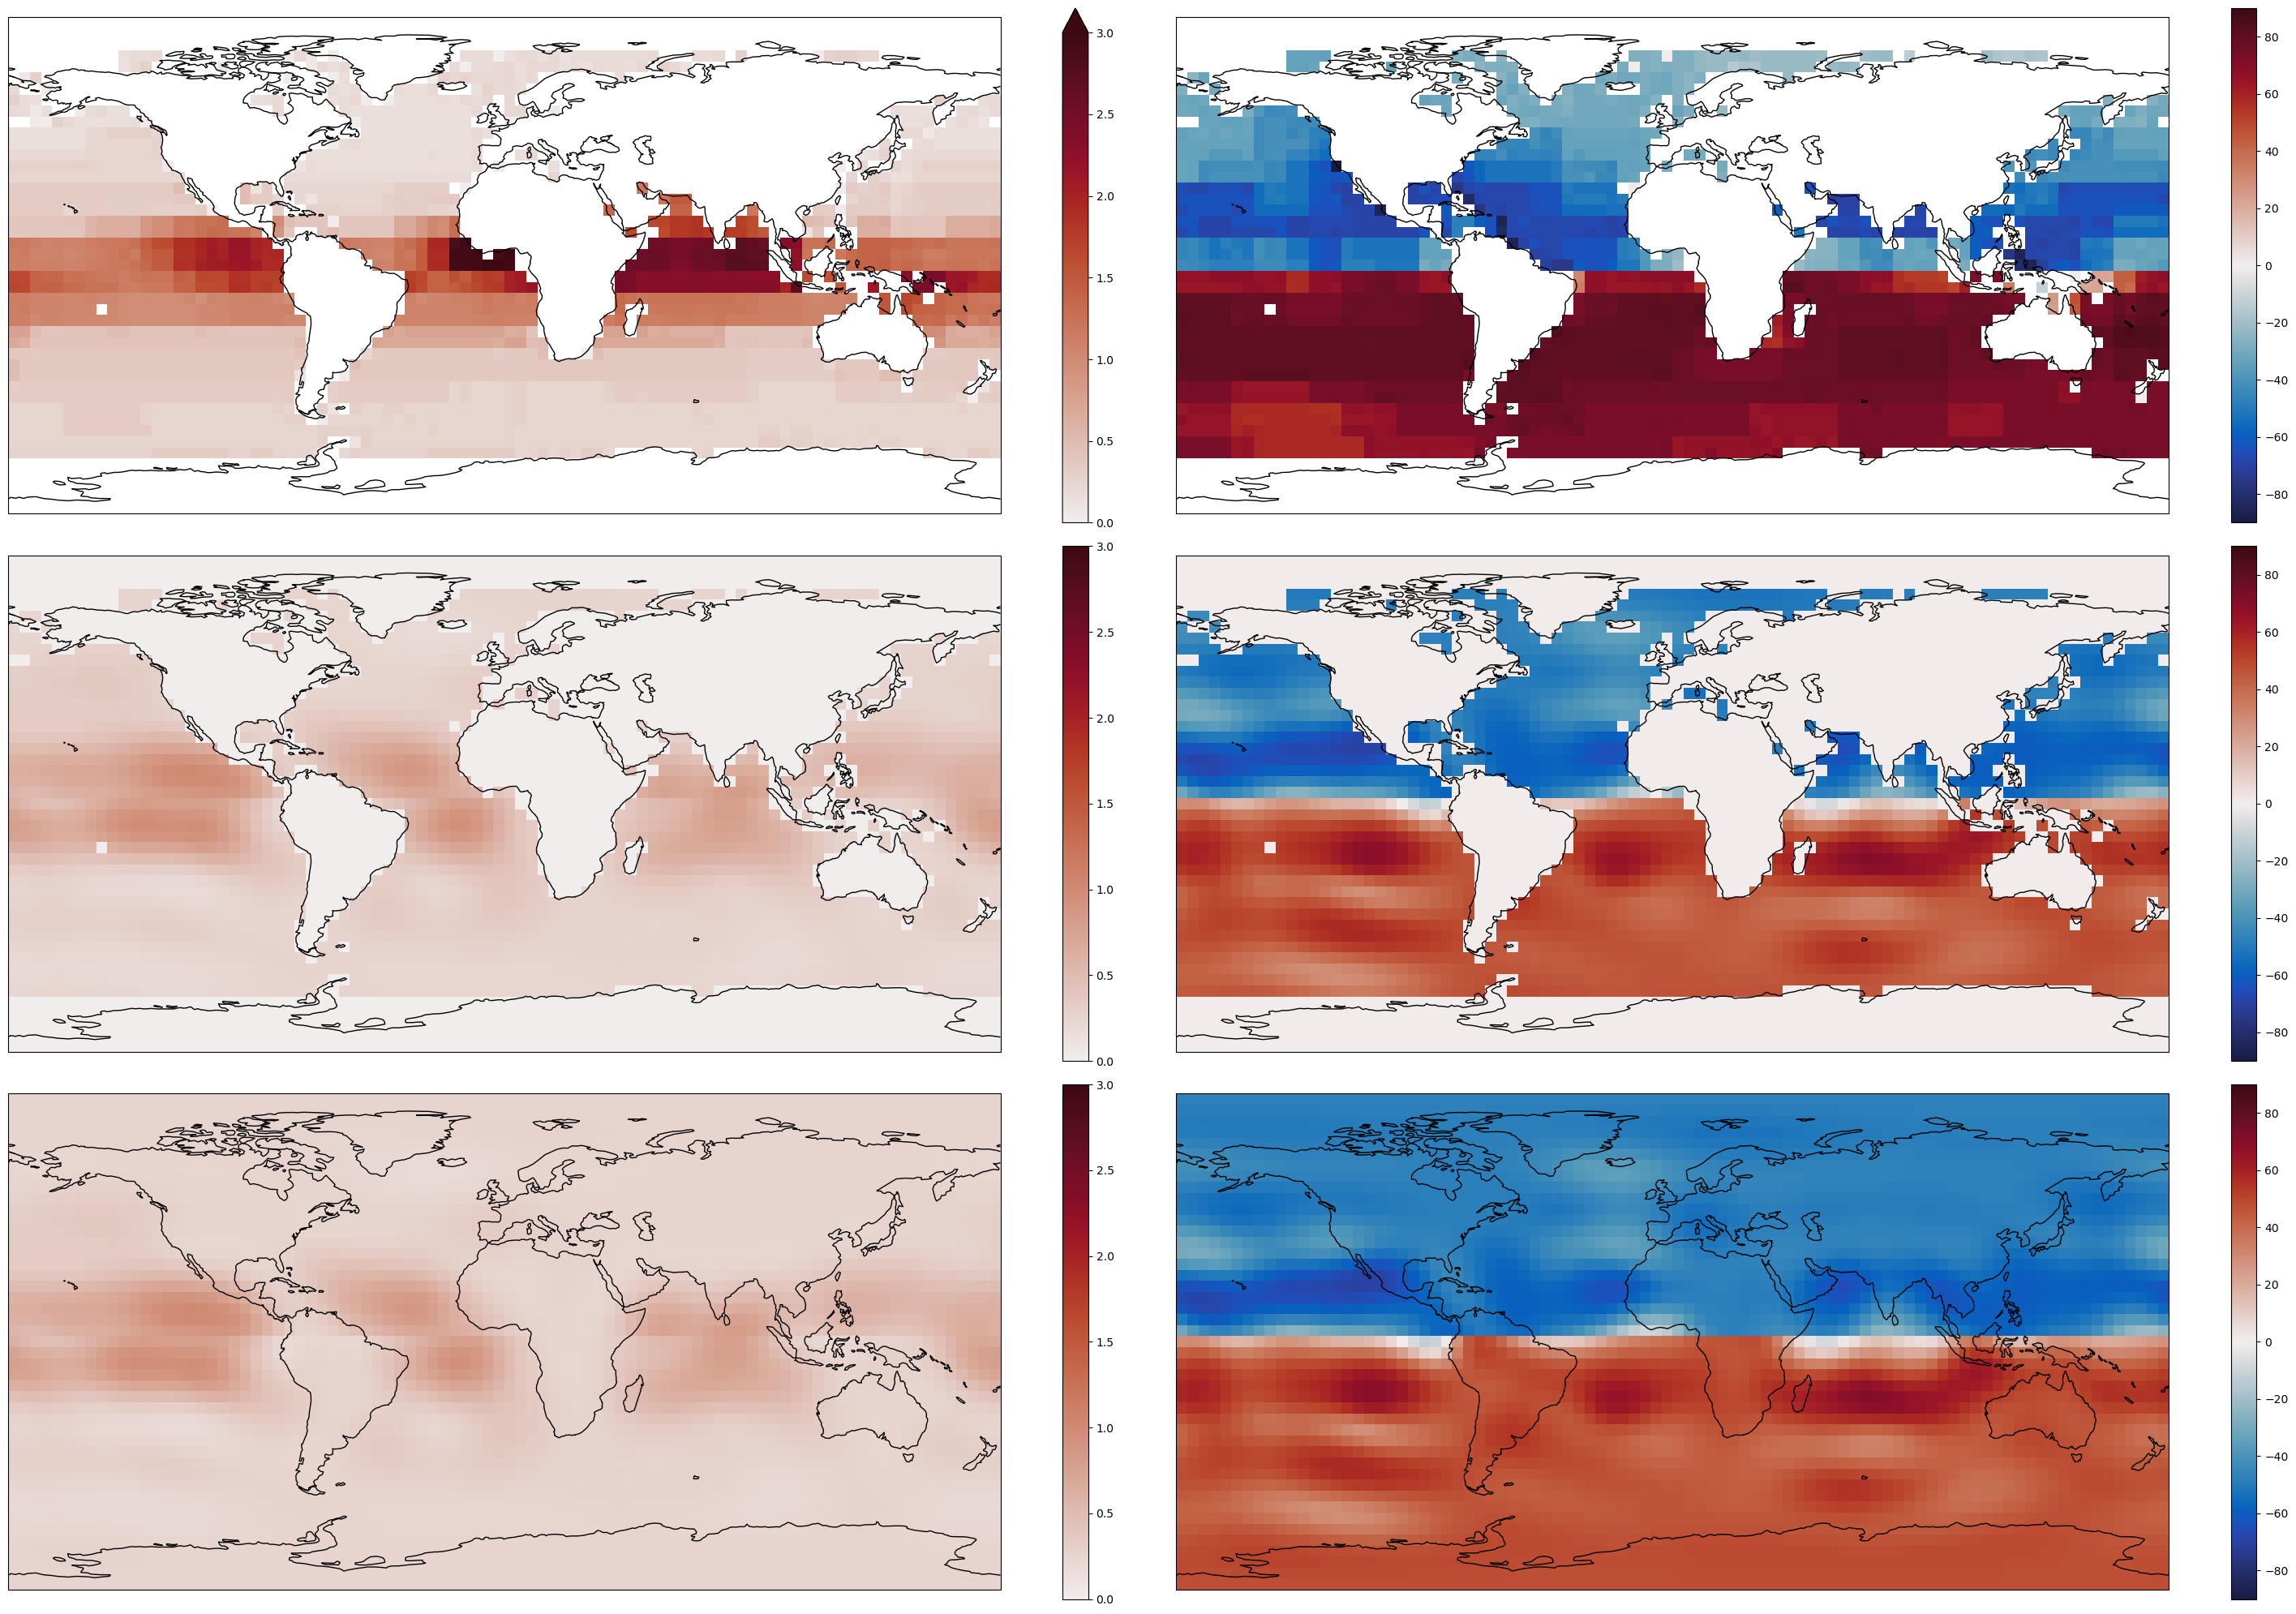

In [126]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(30, 20), subplot_kw={"projection": ccrs.PlateCarree()}
)

beta_rio2014_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_rio2014_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

beta_fit_m_da.plot(ax=ax3, cmap=cmo.amp, vmin=0, vmax=3)
ax3.coastlines()

theta_fit_m_da.plot(ax=ax4, cmap=cmo.balance, vmin=-90, vmax=90)
ax4.coastlines()

beta_fit_da.plot(ax=ax5, cmap=cmo.amp, vmin=0, vmax=3)
ax5.coastlines()

theta_fit_da.plot(ax=ax6, cmap=cmo.balance, vmin=-90, vmax=90)
ax6.coastlines()

fig.tight_layout()
plt.show()